<a href="https://colab.research.google.com/github/Katha-Patel11/MovieReviewAnalysis/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_path = '/content/drive/MyDrive/AI_project/movie-review.zip'
extract_to = '/content/movie-review'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction done.")

Extraction done.


In [3]:
import pandas as pd
import os
def load_reviews_from_folder(folder_path, label):
    reviews = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            reviews.append((text, label))
    return reviews

# Corrected folder paths
base_path = '/content/movie-review/movie_reviews/movie_reviews'
pos_path = os.path.join(base_path, 'pos')
neg_path = os.path.join(base_path, 'neg')

# Load data
pos_reviews = load_reviews_from_folder(pos_path, 1)
neg_reviews = load_reviews_from_folder(neg_path, 0)

# Create DataFrame
all_reviews = pos_reviews + neg_reviews
df = pd.DataFrame(all_reviews, columns=['review', 'label'])

# Preview
df.head()

,review,label
0,eddie murphy has had his share of ups and down...,1
1,let me start off by saying that leading up to ...,1
2,although many people have compared this new ga...,1
3,have you ever wondered if death is something t...,1
4,many people dislike french films for their lac...,1


In [4]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<[^>]+>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df['cleaned_text'] = df['review'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


In [6]:
vectorizer = TfidfVectorizer(max_features=8000)
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['label']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8225

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.77      0.81       201
           1       0.79      0.88      0.83       199

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



In [9]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vector = vectorizer.transform([cleaned])
    prediction = model.predict(vector)[0]
    return 'Positive' if prediction == 1 else 'Negative'

In [10]:
sample_review = "This movie was not that good."
print("Sentiment:", predict_sentiment(sample_review))

Sentiment: Negative


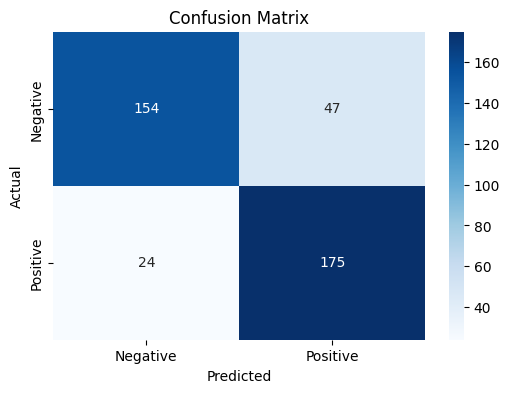

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


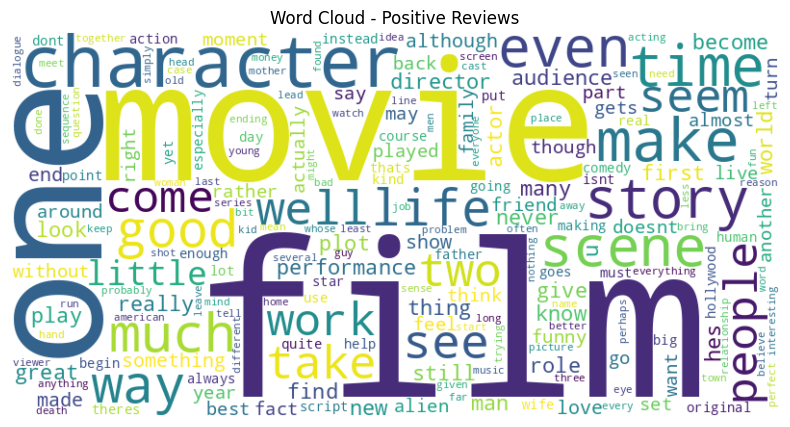

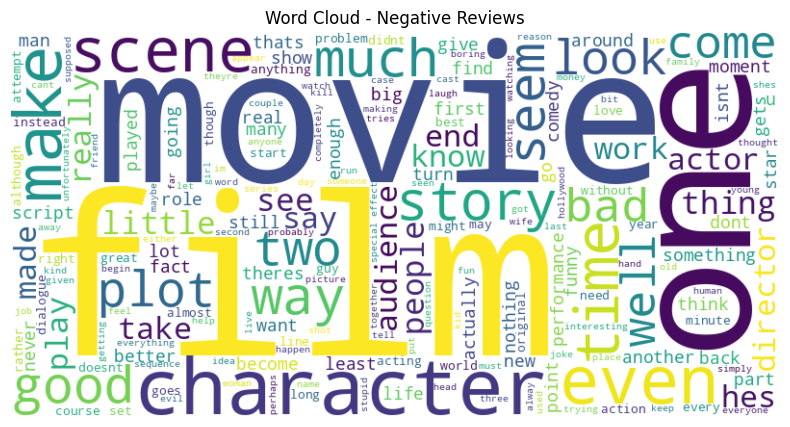

In [12]:
from wordcloud import WordCloud

# Word cloud for positive reviews
pos_text = ' '.join(df[df['label'] == 1]['cleaned_text'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_text)

plt.figure(figsize=(10, 5))
plt.title("Word Cloud - Positive Reviews")
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word cloud for negative reviews
neg_text = ' '.join(df[df['label'] == 0]['cleaned_text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(neg_text)

plt.figure(figsize=(10, 5))
plt.title("Word Cloud - Negative Reviews")
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.show()


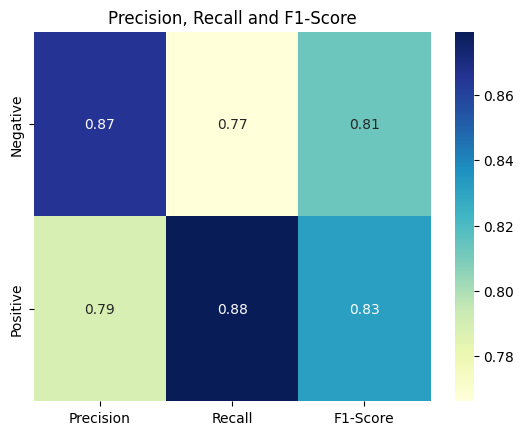

In [33]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
import seaborn as sns
import matplotlib.pyplot as plt

metrics = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}
df_metrics = pd.DataFrame(metrics, index=['Negative', 'Positive'])

sns.heatmap(df_metrics, annot=True, cmap='YlGnBu')
plt.title('Precision, Recall and F1-Score')
plt.show()

In [29]:
import numpy as np

# Get feature names and coefficients
feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = model.coef_[0]

# Top 15 words for positive reviews
top_pos_idx = np.argsort(coefficients)[-15:]
print("Top positive words:", feature_names[top_pos_idx])

# Top 15 words for negative reviews
top_neg_idx = np.argsort(coefficients)[:15]
print("Top negative words:", feature_names[top_neg_idx])


Top positive words: ['truman' 'true' 'best' 'seen' 'american' 'many' 'quite' 'world' 'perfect'
 'family' 'jackie' 'war' 'also' 'great' 'life']
Top negative words: ['bad' 'worst' 'plot' 'boring' 'movie' 'supposed' 'theres' 'stupid'
 'nothing' 'even' 'script' 'unfortunately' 'looks' 'batman' 'waste']


In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.4f}")


Logistic Regression Accuracy: 0.8225
Multinomial Naive Bayes Accuracy: 0.8125
Linear SVM Accuracy: 0.8525
Random Forest Accuracy: 0.8050


In [31]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(LogisticRegression(), X, y, cv=5, scoring='accuracy')
print(f"Cross-validated accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-validated accuracy: 0.8445 ± 0.0158


In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best C:", grid.best_params_['C'])
print("Best CV score:", grid.best_score_)

Best C: 10
Best CV score: 0.8550000000000001


In [38]:
user_review = input("Enter your movie review: ")
print("Predicted Sentiment:", predict_sentiment(user_review))

Enter your movie review: This movie was a great watch
Predicted Sentiment: Positive
